In [1]:
import torch
import torch.utils.data as Data
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


### Read training data and prepare numpy array input for LSTM NN

In [3]:
fname1 = "body_acc_x_train.xlsx"  #the data file is located at the same directory
dfX1=pd.read_excel(fname1, header=None)

In [4]:
fname2 = "body_acc_y_train.xlsx"  #the data file is located at the same directory
dfX2=pd.read_excel(fname2, header=None)

In [5]:
fname3 = "body_acc_z_train.xlsx"  #the data file is located at the same directory
dfX3=pd.read_excel(fname3, header=None)

In [6]:
fname4 = "y_train.xlsx"  #the data file is located at the same directory
dfY=pd.read_excel(fname4, header=None)

In [7]:
print(dfX1.shape, dfX2.shape, dfX3.shape, dfY.shape)

(7352, 128) (7352, 128) (7352, 128) (7352, 1)


In [8]:
# 練習: get the number of rows and columns of a data frame
print(dfX1.shape[0], dfX1.shape[1])

7352 128


In [9]:
# 練習: print first two rows
dfX1.head(2)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599


In [10]:
# 練習: get the value at the ith column and jth row of a data frame
ColumnIdx = 5  # column index
RowIdx = 1  # row index

value = dfX1.iloc[RowIdx, ColumnIdx]
print(value)

0.002415886


In [11]:
# Input: 7352 data, each data contains 3 time-series (acceleartion x, y, z) with 128 time steps
NoOfData = dfX1.shape[0]
NoOfFeatures = 3  #x, y, z
TIME_STEPS = dfX1.shape[1]

Input to LSTM: x = [No of data, No. of features, Time steps] <br>
Each data contains No_of_features time series. The length of each time series is Time_steps 

In [12]:
# 練習: get one data, which contains No. of features time series data of length Time steps
# [No. of features, Time steps] = [3, 128]
xLst = []
RowIdx = 0 # the first row of each data file
for ColumnIdx in range(TIME_STEPS): #loop through the 128 columns of each file
        xLst1 = [dfX1.iloc[RowIdx, ColumnIdx], dfX2.iloc[RowIdx, ColumnIdx], dfX3.iloc[RowIdx, ColumnIdx]]
        xLst.append(xLst1)
numpyX = np.array(xLst)
print(numpyX.shape)

(128, 3)


In [13]:
numpyX = np.transpose(numpyX)
print(numpyX.shape)

(3, 128)


In [14]:
# loop to prepare input to LSTM: x = [No of data, No. of features, Time steps] <br>
xLst = []
yLst = []
for RowIdx in range(NoOfData): #each data
    xLst1 = []
    for ColumnIdx in range(TIME_STEPS): #each time step
        xLst2 = [dfX1.iloc[RowIdx, ColumnIdx], dfX2.iloc[RowIdx, ColumnIdx], dfX3.iloc[RowIdx, ColumnIdx]]
        xLst1.append(xLst2)
    xLst.append(xLst1)
    yLst.append(dfY.iloc[RowIdx, 0])

In [15]:
numpyX = np.array(xLst)
numpyY = np.array(yLst)
print(numpyX.shape, numpyY.shape)

(7352, 128, 3) (7352,)


In [16]:
numpyX = numpyX.transpose((0, 2, 1))
print(numpyX.shape)

(7352, 3, 128)


### Define LSTM NN

Ref: http://chandlerzuo.github.io/blog/2017/11/darnn

In [17]:
BATCH_SIZE = 512  #1/10 of training data, 7352*0.8*0.1=588

In [18]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(3, 64) #NoOfFeatures=3
        self.lstm2 = nn.LSTMCell(64, 64)
        self.linear = nn.Linear(64, 6) # 6 activities

    def forward(self, x):
        # input x = (BATCH_SIZE, features, TIME_STEPS), h,c.shape=(BATCH_SIZE, 64)
        h1 = torch.zeros(BATCH_SIZE, 64).to(device) 
        c1 = torch.zeros(BATCH_SIZE, 64).to(device)
        h2 = torch.zeros(BATCH_SIZE, 64).to(device)
        c2 = torch.zeros(BATCH_SIZE, 64).to(device)
        
        # iterate through time steps
        for i in range(TIME_STEPS):
            h1, c1 = self.lstm1(x[:, :, i], (h1, c1))
            h2, c2 = self.lstm2(h1, (h2, c2))
            output = self.linear(h2)
        return output

In [19]:
model = Sequence().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### For the 1st time, go to Appendix to practice training loop step by step

### Training loop


In [35]:
num_epochs = 500

In [42]:
train_lossLst = []
validation_lossLst = []

In [43]:
# split training data to train and validation
trainX, validationX, trainY, validationY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)

In [44]:
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_validationX = torch.FloatTensor(validationX).to(device)
tensor_trainY = torch.LongTensor(trainY).to(device)
tensor_validationY = torch.LongTensor(validationY).to(device)

In [45]:
train_dataset = Data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = Data.DataLoader(
    dataset=train_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [46]:
validation_dataset = Data.TensorDataset(tensor_validationX, tensor_validationY)
validation_loader = Data.DataLoader(
    dataset=validation_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [48]:
for epoch in range(num_epochs):
    if(epoch%50 == 0):
      print(epoch, end=",")
      
    epoch_lossLst=[]
    for batchX, batchY in train_loader:
        # last batch, batch size may be less than BATCH_SIZE
        if(batchX.size(0) != BATCH_SIZE):
            break
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        batchY = batchY-1   # y has to be 0~5
        output = model(batchX)
        loss = loss_func(output, batchY)
        epoch_lossLst.append(float(loss))
        optimizer.zero_grad()
        loss.backward ()
        optimizer.step()
    avg = sum(epoch_lossLst)/len(epoch_lossLst)
    train_lossLst.append(avg) 

    #test with validation data
    epoch_lossLst=[]
    for batchX, batchY in validation_loader:
        # last batch, batch size may be less than BATCH_SIZE
        if(batchX.size(0) != BATCH_SIZE):
            break
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        batchY = batchY-1   # y has to be 0~5
        output = model(batchX)
        loss = loss_func(output, batchY)
        epoch_lossLst.append(float(loss))
    avg = sum(epoch_lossLst)/len(epoch_lossLst)
    validation_lossLst.append(avg) 

0,50,100,150,200,250,300,350,400,450,

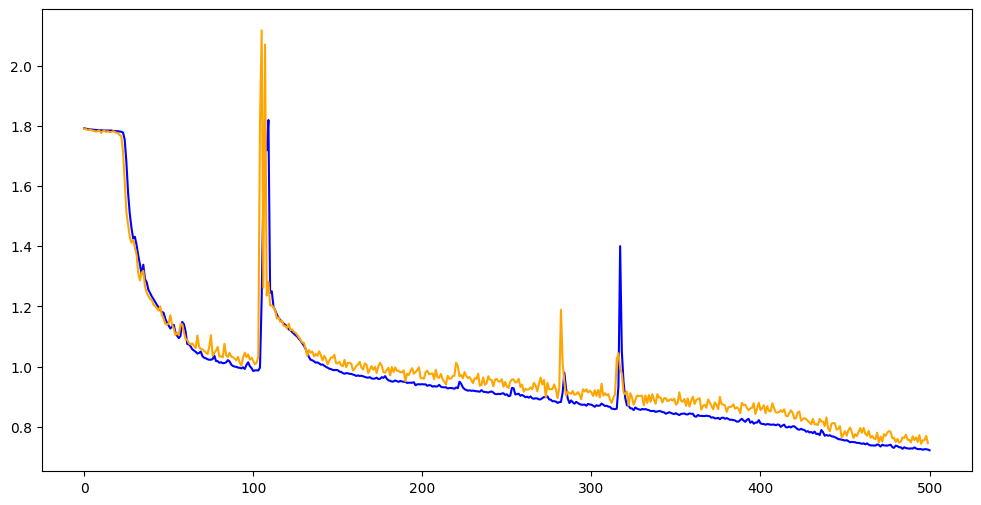

In [49]:
fig=plt.figure(figsize=(12, 6))
plt.plot(train_lossLst, color='blue')
plt.plot(validation_lossLst, color='orange')
plt.show()

Note: You should repeat training several times and observe train-validataion loss plot

# Test

In [50]:
fname1 = "body_acc_x_test.xlsx"  #the data file is located at the same directory
dfX1=pd.read_excel(fname1, header=None)

fname2 = "body_acc_y_test.xlsx"  #the data file is located at the same directory
dfX2=pd.read_excel(fname2, header=None)

fname3 = "body_acc_z_test.xlsx"  #the data file is located at the same directory
dfX3=pd.read_excel(fname3, header=None)

fname4 = "y_test.xlsx"  #the data file is located at the same directory
dfY=pd.read_excel(fname4, header=None)

In [51]:
# make sure data consistency
print(dfX1.shape, dfX2.shape, dfX3.shape, dfY.shape)

(2947, 128) (2947, 128) (2947, 128) (2947, 1)


In [52]:
NoOfData = dfX1.shape[0]
NoOfFeatures = 3  #x, y, z
TIME_STEPS = dfX1.shape[1]

In [53]:
# loop to prepare input to LSTM: x = [No of data, No. of features, Time steps] 
xLst = []
yLst = []
for RowIdx in range(NoOfData): #each data
    xLst1 = []
    for ColumnIdx in range(TIME_STEPS): #each time step
        xLst2 = [dfX1.iloc[RowIdx, ColumnIdx], dfX2.iloc[RowIdx, ColumnIdx], dfX3.iloc[RowIdx, ColumnIdx]]
        xLst1.append(xLst2)
    xLst.append(xLst1)
    yLst.append(dfY.iloc[RowIdx, 0])

In [54]:
numpyX = np.array(xLst)
numpyY = np.array(yLst)

numpyX = numpyX.transpose((0, 2, 1))
print(numpyX.shape, numpyY.shape)

(2947, 3, 128) (2947,)


In [55]:
tensor_testX = torch.FloatTensor(numpyX).to(device)
tensor_testY = torch.LongTensor(numpyY).to(device)

In [56]:
BATCH_SIZE = 512 

In [57]:
test_dataset = Data.TensorDataset(tensor_testX, tensor_testY)
test_loader = Data.DataLoader(
    dataset=train_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [58]:
for batchX, batchY in test_loader:
    break

In [59]:
batchY = batchY-1

In [60]:
# 練習: take a look at first 10 data
print(batchY[:10])

tensor([4, 3, 5, 0, 5, 1, 1, 0, 5, 2], device='cuda:0')


In [61]:
batchY_hat = model(batchX)
print(batchY_hat.shape)

torch.Size([512, 6])


In [62]:
batchY_hat = torch.softmax(batchY_hat, 1)
MaxIdxOfEachRow = torch.max(batchY_hat, 1)[1]

In [64]:
conf_matrix = confusion_matrix(batchY.cpu().numpy(), MaxIdxOfEachRow.cpu().numpy())

<Axes: >

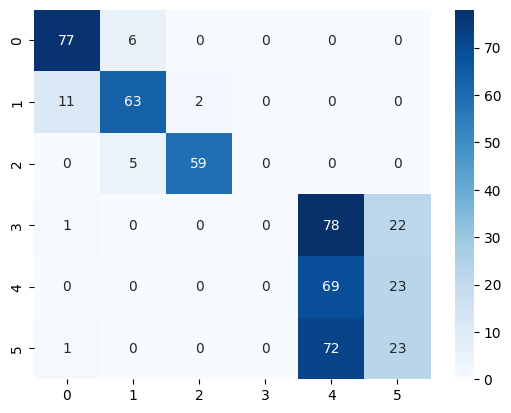

In [65]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

you can get another batch of test data and check the confusion matrix

# Appendix 
練習: Send a batch of input data to LSTM step by step

In [20]:
# split training data to train and validation
trainX, validationX, trainY, validationY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, validationX.shape, trainY.shape, validationY.shape)

(5881, 3, 128) (1471, 3, 128) (5881,) (1471,)


In [21]:
tensor_trainX = torch.FloatTensor(trainX).to(device)
tensor_trainY = torch.LongTensor(trainY).to(device)

In [22]:
# define data loader
train_dataset = Data.TensorDataset(tensor_trainX, tensor_trainY)
train_loader = Data.DataLoader(
    dataset=train_dataset,  
    batch_size=BATCH_SIZE,      
    shuffle=True,       
    num_workers=0,   
)

In [23]:
# 練習: get a batch of data
for batchX, batchY in train_loader:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        break
print(batchX.shape, batchY.shape)

torch.Size([512, 3, 128]) torch.Size([512])


In [24]:
# 練習: LSTM cell details
h1 = torch.zeros(BATCH_SIZE, 64).to(device) 
c1 = torch.zeros(BATCH_SIZE, 64).to(device)
h2 = torch.zeros(BATCH_SIZE, 64).to(device)
c2 = torch.zeros(BATCH_SIZE, 64).to(device)

In [25]:
h1, c1 = model.lstm1(batchX[:, :, 0], (h1, c1))

In [26]:
h2, c2 = model.lstm2(h1, (h2, c2))

In [27]:
output = model.linear(h2)
print(output.shape)

torch.Size([512, 6])


In [28]:
# 練習: LSTM cell details
for i in range(TIME_STEPS):
    h1, c1 = model.lstm1(batchX[:, :, i], (h1, c1))
    h2, c2 = model.lstm2(h1, (h2, c2))
    output = model.linear(h2)

練習: pass batchX to model, calculate loss, backward propagation

In [29]:
# 練習: get a batch of data
for batchX, batchY in train_loader:
        batchX = batchX.to(device)
        batchY = batchY.to(device)
        break
print(batchX.shape, batchY.shape)

torch.Size([512, 3, 128]) torch.Size([512])


In [30]:
print(torch.min(batchY), torch.max(batchY))

tensor(1, device='cuda:0') tensor(6, device='cuda:0')


In [31]:
# y has to be 0~5
batchY = batchY-1
print(torch.min(batchY), torch.max(batchY))

tensor(0, device='cuda:0') tensor(5, device='cuda:0')


In [32]:
# 練習: pass batchX to model
batchY_hat = model(batchX)
print(batchY_hat.shape)

torch.Size([512, 6])


In [33]:
loss = loss_func(batchY_hat, batchY)
print(float(loss))

1.7916897535324097


In [34]:
optimizer.zero_grad()
loss.backward()
optimizer.step()